In [2]:
# This notebook will compare results achieved with the Adam optimizer and the recently introduced AdaBelief optimizer!
# We will perform binary text classification on imdb reviews!
# The AdaBelief optimizer simultaneously achieves three goals: fast convergence as in adaptive
# methods(eg. Adam), good generalization as in SGD, and training stability!

In [3]:
!pip install -q tensorflow_datasets 

In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [5]:
import matplotlib.pyplot as plt
# function to plot graphs for loss/accuracy vs number of epochs
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [6]:
# load the imdb reviews dataset, make test and train sets
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# training data is shuffled and a batch size of 64 will be used
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This is one of the movies of Dev Anand who gave great yet distinct movies to Hindi movie industries such as Jewel thief and guide. The story is short (if you ask me what is the story), plot is simple- a brother seeks for his lost sister. Sister has joined the hippies who smoke from pot and chant Hare Rama hare Krishna. Yet the movie portrays few of the significant events that the world experienced in 70's.Hippie culture, their submission to drugs, freedom ,escaping duty, family, and adopting anything new such as eastern (which was new for whites) religion. They have been handled perfectly. Zeenat gave her best and Dev as usual was remarkable. Songs are the best used (unlike they are abused for the sake of having songs) in this movie. They have not been spoiled.One perfect example is 'Dekho o deewano...Ram ka naam badnam na karo'. Each word in the song is very philosophical and meaningful. The end is tragic but that is not the essence of the movie. Overall Devji who does beli

In [11]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE) # the text vectorization layer creates an encoder to process raw data for input into the model
encoder.adapt(train_dataset.map(lambda text, label: text)) # adapt layer sets the vocabulary

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [13]:
# we can now encode text into indices
encoded_example = encoder(example)[:3].numpy() 
encoded_example
# tensors are zero padded to match longest sequence in batch

array([[ 11,   7,  29, ...,   0,   0,   0],
       [283,  77,  26, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0]], dtype=int64)

In [15]:
# An Embedding layer followed by a bidirectional LSTM layer will be the basis of our keras model!
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
# First we train our model with Adam!

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 33s 83ms/step - loss: 0.6597 - accuracy: 0.5370 - val_loss: 0.5419 - val_accuracy: 0.6479
Epoch 2/10
391/391 [==============================] - 30s 78ms/step - loss: 0.4120 - accuracy: 0.8050 - val_loss: 0.3652 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3412 - accuracy: 0.8511 - val_loss: 0.3438 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3195 - accuracy: 0.8603 - val_loss: 0.3272 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3148 - accuracy: 0.8634 - val_loss: 0.3250 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 30s 78ms/step - loss: 0.3072 - accuracy: 0.8674 - val_loss: 0.3203 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3031 - accuracy: 0.8688 - val_loss: 0.3196 - val_accuracy:

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 14s 35ms/step - loss: 0.3168 - accuracy: 0.8518
Test Loss: 0.3167639970779419
Test Accuracy: 0.8518400192260742


(0.0, 0.6776975005865097)

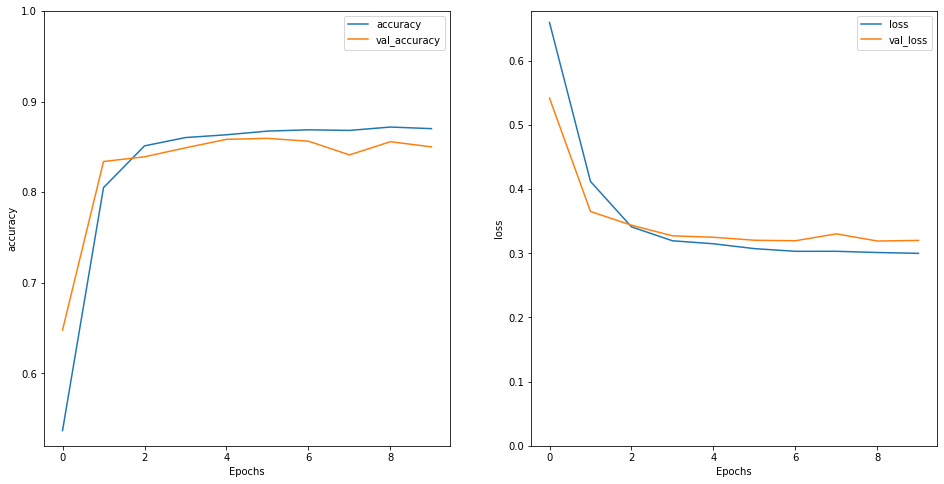

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [23]:
!pip install adabelief-tf==0.2.0 

In [24]:
from adabelief_tf import AdaBeliefOptimizer

In [30]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=AdaBeliefOptimizer(1e-4,rectify=False), # This time, we use the AdaBelief optimizer!
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.0)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Epoch 1/10
391/391 [==============================] - 34s 88ms/step - loss: 0.6270 - accuracy: 0.

(0.0, 0.6432123333215714)

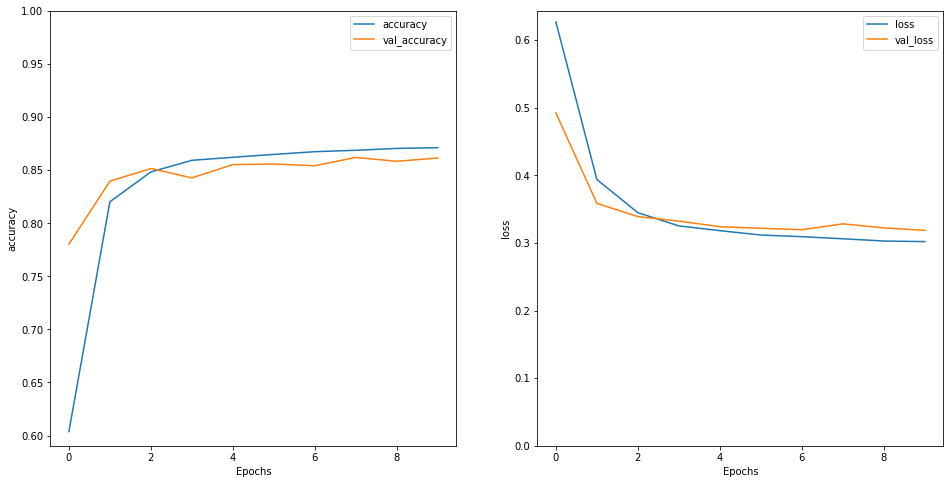

In [33]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)
# For the same number of epochs, the AdaBelief optimizer gives better validation accuracy and loss at the end of 10 epochs!